# Demo of polygon subsetting for ORNL DAAC OGC Services


This notebook is in three sections, the first demonstrating the prerequisites that subsets from all services will require (that applies to the rasterization portion of section two as well), and the second and third show how to do the subsetting through THREDDS OPeNDAP and SDAT WCS services:
1. [handling input vector dataset, including reprojection if necessary](#1.-Handling-input-vector-dataset)
2. [polygon subset of the same Daymet grnaule through SDAT WCS service](#2.-Download-polygon-subset-from-SDAT-WCS-Service)

--->>> fix link 2. [polygon subsetting of Daymet granule through THREDDS OPeNDAP service](#2.-THREDDS-polygon-subset-example-through-OPeNDAP)

Also, We use `xarray` here instead of `netCDF4` because it's simpler, but they can be swapped easily if this is the general approach that we end up taking to do the polygon subsetting.

-------------------

## 1. Handling input vector dataset

**import GDAL/OGR and read example shapefile**

In [2]:
from osgeo import gdal, ogr, osr

# an example polygon (1) shapefile
input_polygon = "example_poly/geo.shp"

# daymet's proj4
daymet_srs = (
    '+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 '
    '+y_0=0 +a=6378137 +b=6356752.314706705 +units=m +no_defs ')

The input polygon is a shapefile in WGS84 in this case, but the first step is to reproject into daymet projection so this code as it is will support any projection and OGR-supported format:

In [3]:
shp = ogr.Open(input_polygon)    # open shapefile
lyr = shp.GetLayer()             # get first (and only) layer
feat = lyr.GetFeature(0)         # select the layer's only feature
geom = feat.GetGeometryRef()     # get feature's geometry
ext = lyr.GetExtent()            # get its extent

ext

(-111.99594029999994,
 -111.27275125999992,
 34.93856156000005,
 35.58533901000003)

**Here's a map widget to see location of the polygon. None of the code in this blocked in necessary to the workflow:**

In [4]:
from ipyleaflet import Map, GeoJSON, basemaps, basemap_to_tiles
import json

Map(layers=(
        GeoJSON(data=json.loads(geom.ExportToJson())),
        basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-05-01"),),
    center=((ext[2]+ext[3])/2, (ext[0]+ext[1])/2),
    scroll_wheel_zoom=True,
    zoom=9)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## 2. Download polygon subset from SDAT WCS Service

We can take advantage of GDAL's virtual dataset functionality here to open a raster that is served through WCS. This is the WCS access point for the same granule that we accessed before through OPeNDAP:

In [9]:
xres = 0.008983112
yres = 0.008983112

wcsurl = ("https://webmap.ornl.gov/ogcbroker/wcs?"
       "originator=Jupyter&"
       "service=WCS&"
       "version=1.0.0&"
       "request=GetCoverage&"
       "coverage=1345_230&"
       "crs=EPSG:4326&"
       "bbox={xmin},{ymin},{xmax},{ymax}&"
       "resx={xres}&"
       "resy={yres}&"
       "format=GeoTIFF_FLOAT32&"
       "time=1980-01&"
       "bands=1&"
       "interpolation=NEAREST")

wcsurl = wcsurl.format(
    xmin=ext[0],
    ymin=ext[2],
    xmax=ext[1],
    ymax=ext[3],
    xres=xres,
    yres=yres)

wcsurl

'https://webmap.ornl.gov/ogcbroker/wcs?originator=Jupyter&service=WCS&version=1.0.0&request=GetCoverage&coverage=1345_230&crs=EPSG:4326&bbox=-111.99594029999994,34.93856156000005,-111.27275125999992,35.58533901000003&resx=0.008983112&resy=0.008983112&format=GeoTIFF_FLOAT32&time=1980-01&bands=1&interpolation=NEAREST'

**vsicurl** goes in front of the URL to read directly into virtual raster dataset. And subsetting has already been done for us:

In [10]:
tif = gdal.Open("/vsicurl/"+wcsurl)
tif

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000027BD1F85330> >

In [11]:
dir(tif)

['AddBand',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction',
 'SetDescription',
 'SetGCPs',
 'SetGeoTransform',
 'SetMetadata',
 'SetMetadataItem',
 'SetProjection',
 'SetStyleTable',
 'StartTransaction',

Ready for plotting, but you have to import matplotlib this time because there is no plotting functionality built into GDAL.

Also, `numpy` is obviously going to be required no matter what approach you take for this. GDAL's arrays are numpy objects, xarray's too. But I'm not sure if GDAL exposes these numpy functions to the user, so import numpy here too:

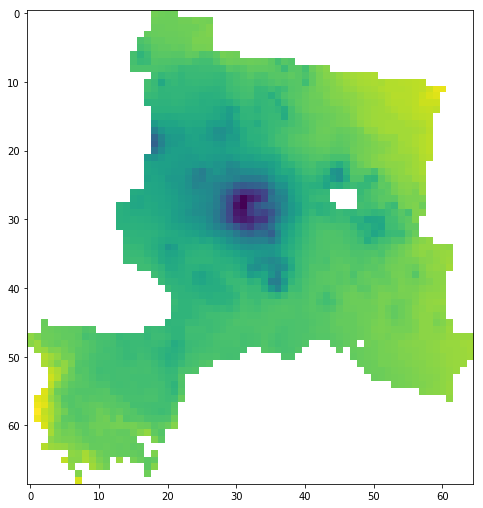

In [15]:
import numpy as np                               # good practice to use np where possible
import matplotlib.pyplot as plt                  # not req; for plotting
plt.rcParams['figure.figsize'] = 8, 10           # not req; for plotting

# read the array from the raster band
array = tif.GetRasterBand(1).ReadAsArray()   

# use the numpy array mask this time
array_masked = np.ma.masked_where(m==0, array)
plt.imshow(array_masked)

In [16]:
tif = None  # close the file

### OGR implementation for reprojecting the layer

You may want to use a higher level package for this in production code... ?? `Fiona` is a good option; it's a python API for OGR without any third-party mess. 

**Get osr transform:**

In [4]:
source_srs = lyr.GetSpatialRef()                                 # get srs
target_srs = osr.SpatialReference()                              # output srs
target_srs.ImportFromProj4(daymet_srs)                           # import daymet proj

transform = osr.CoordinateTransformation(source_srs, target_srs) # the transformation

**Reproject input geometry to daymet lcc:**

In [5]:
geom.Transform(transform)                                        # transform to daymet lcc

geom

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x0000022D4B975B10> >

**Make a memory ogr vector layer:**

In [6]:
memvector = ogr.GetDriverByName('Memory').CreateDataSource('mem')  # open OGR vector memory dataset
memlyr = memvector.CreateLayer('poly', srs=target_srs)             # make a dummy layer in daymet lcc
memfeat = ogr.Feature(memlyr.GetLayerDefn())                       # init a dummy feature
memfeat.SetGeometryDirectly(geom)                                  # set transformed geom to feature
memlyr.CreateFeature(memfeat)                                      # add dummy feature to layer

lccext = memlyr.GetExtent()                                        # get the lcc extent for the next step
lccext

(-1049272.0963564266,
 -985164.9821343779,
 -729249.6405806087,
 -660885.2073472433)

## 2. THREDDS polygon subset example through OPeNDAP

If opendap turns out to be practical for a production polygon subsetting service, we can reduce the following steps even more. This method is very fast because no data is being read until the very last step where I call the plotting function. 

OPeNDAP gives us access to the file's header so that we can queue a series of operations that, using the coordinate arrays that define the position of the data along the x,y dimensions, index only what's inside our polygon and ignore data that we don't care about, keeping the download volume very small. 

The really powerful capability here is that netCDF provides a mechanism to treat many similarly-structured granules in THREDDS as a single granule, a virtual dataset, assuming the data are structured in a way that's close to CF compliant:

In [7]:
import xarray as xr

opendap_netcdf = ('https://thredds.daac.ornl.gov/thredds/dodsC/'
                 'ornldaac/1328/1980/daymet_v3_tmin_1980_na.nc4')

nc = xr.open_dataset(opendap_netcdf)
nc

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 365, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-30T12:00:00
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmin                     (time, y, x) float32 ...
Attributes:
    start_year:                      1980
    source:                          Daymet Software Version 3.0
    Version_software:                Daymet Software Version 3.0
    Version_data:                    Daymet Data Version 3.0
    Conventions:                     CF-1.6
    citation:         

**Note that only the coordinate variables that define the position of observations along the dimensions time, x, y are downloaded with the file's header. The rest of the data are represented by ellipses ...**

Select only the data inside the extent of the reprojected polygon:

In [8]:
nc_subset = nc.sel(                 # you select by dim coordinate using <dataset>.sel()
    time="1980-01-01",              # only gonna get 1 time step
    x=slice(lccext[0],lccext[1]),   # the x coordinate slice
    y=slice(lccext[3],lccext[2]))   # the y coordinate slice

nc_subset                           # print the result:

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 1, x: 65, y: 69)
Coordinates:
  * x                        (x) float32 -1049250.0 -1048250.0 ... -985250.0
  * y                        (y) float32 -661000.0 -662000.0 ... -729000.0
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmin                     (time, y, x) float32 ...
Attributes:
    start_year:                      1980
    source:                          Daymet Software Version 3.0
    Version_software:                Daymet Software Version 3.0
    Version_data:                    Daymet Data Version 3.0
    Conventions:                     CF-1.6
    citation:                        Please see http:

Dang, so simple...

### GDAL implementation for rasterizing the layer
Maybe use some higher-level package in production code here too.. ?

**Get GDAL geotransform for daymet subset:**

In [9]:
ncols = nc_subset.x.size               # most of this is self-explanatory
nrows = nc_subset.y.size               # get number cols, rows

ymax = nc_subset.y.max().data.item()   # get lcc extent
ymin = nc_subset.y.min().data.item()
xmax = nc_subset.x.max().data.item() 
xmin = nc_subset.x.min().data.item()

yres = (ymax-ymin)/float(nrows)        # get x,y resolution
xres = (xmax-xmin)/float(ncols)

geotransform = (                       # put that info into affine tuple that
    xmin, xres, 0, ymax, 0, -yres)     #  gdal uses to define transformation

geotransform

(-1049250.0, 984.6153846153846, 0, -661000.0, 0, -985.5072463768116)

**Make GDAL raster dataset in memory of rasterized polygon:**

*inside polygon == 1 ; outside polygon == 0*

In [10]:
memras = gdal.GetDriverByName('MEM').Create(   # open memory raster
    '',                                         # no file path required
    ncols,                                      # number of cols in mask should match nc_subset
    nrows,                                      # same for rows
    1,                                          # **the number of bands**
    gdal.GDT_Byte)                              # and the output type is byte because we only want 0,1

band = memras.GetRasterBand(1)                  # select band 1
band.Fill(0)                                    # fill with zeros
band.SetNoDataValue(0)                          # set nodata value to 0
memras.SetGeoTransform(geotransform)            # set geotransform
memras.SetProjection(target_srs.ExportToWkt())  # copy projection used for lcc memory vector

err = gdal.RasterizeLayer(                     # rasterize memory vector layer
    memras,                                     # memory raster 
    [1],                                        # band 1
    memlyr,                                     # memory vector layer
    burn_values=[1])                            # polygon area == 1
memras.FlushCache()                            # "write" changes 

m = memras.GetRasterBand(1).ReadAsArray()      # get the result as numpy array
print(m.min()); print(m.max())                 # check by printing min,max

0
1


**Optional, but add the mask as a new variable in the `xarray.Dataset`**:

In [11]:
nc_subset['mask'] = xr.DataArray(                   # add a new variable
    m,                                              #  the mask array (numpy type)
    coords=[nc_subset.y, nc_subset.x],              #  the coordinate arrays from target ds
    dims=['y','x'],                                 #  the names of the dimensions for mask
    attrs={                                         #  and some totally unnecessary attributes
        'grid_mapping':'lambert_conformal_conic',
        'flag_values': (0,1),
        'flag_meanings': 'nodata data',
        '_FillValue': 0})

nc_subset

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 1, x: 65, y: 69)
Coordinates:
  * x                        (x) float32 -1049250.0 -1048250.0 ... -985250.0
  * y                        (y) float32 -661000.0 -662000.0 ... -729000.0
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmin                     (time, y, x) float32 ...
    mask                     (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    start_year:                      1980
    source:                          Daymet Software Version 3.0
    Version_software:                Daymet Software Version 3.0
    Version_data:                    Daymet Data Version 3.0
    Conventions: 

**But you could just give them this:**

(we use the dataset mask here, but it's just as simple to use numpy if you think it's better to skip the previous step)

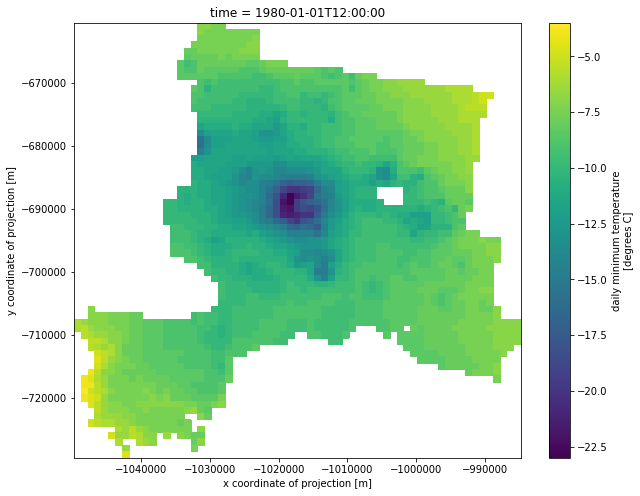

In [12]:
# this is just to render the plot in jupyter notebook
%matplotlib inline

# set tmin to the NA where mask==1;
nc_subset['tmin'] = nc_subset['tmin'].where(nc_subset.mask==1)

# the result, tada:
nc_subset['tmin'].plot(figsize=(10,8))